#Basics of Math Behind Neural Networks

Neural networks are built on basic math concepts like functions and derivatives. Here we start with a simple quadratic function to show how derivatives measure the slope of a function at any point. This is the foundation for understanding how neural networks learn.

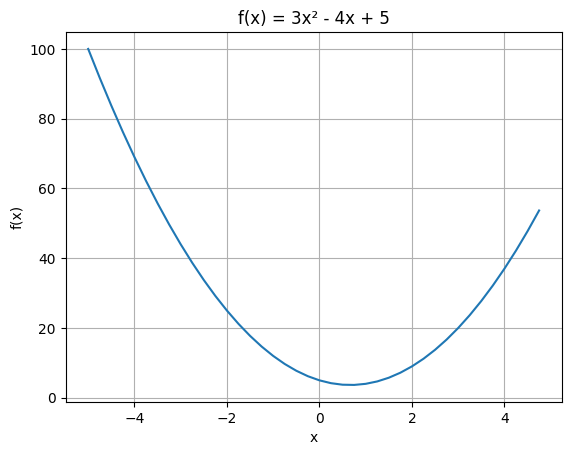

Approximate derivative at x = 3.0: 14.00003000000538


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Define a simple quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

# Generate values for x and compute f(x)
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

# Plot the curve of f(x)
plt.plot(xs, ys)
plt.title("f(x) = 3x² - 4x + 5")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

# Let's approximate the derivative using a small step (h)
h = 0.00001
x = 3.0
slope = (f(x + h) - f(x)) / h
print(f"Approximate derivative at x = {x}: {slope}")


#Finding the Derivative — f'(x) = (f(x+h) - f(x)) / h

**What does the slope mean?**

The slope (or derivative) tells you how fast and in what direction the function value is changing at a specific x.

If the slope is **positive**, the function is **increasing** — moving upward as x increases.

If the slope is **negative**, the function is **decreasing** — going downward as x increases.

If the slope is 0, the function is flat — it’s at a minimum or maximum point.


We can estimate it numerically by taking a very small step h. This is called the finite difference method.

Let’s calculate it manually and then extend the concept to a small equation with multiple variables.


In [3]:
h = 0.00001
x = 3.0

# Approximate derivative of f(x)
print((f(x + h) - f(x)) / h)

# Using calculus, the exact derivative is:
# f'(x) = 6x - 4
# f'(3) = 6*3 - 4 = 14


14.00003000000538


**Getting a Bit More Complex**

Now let’s take a simple equation with multiple variables:


**d=a∗b+c**

We’ll compute how much d changes when we make a tiny change in a — that’s the derivative of  **d** **with** **respect** **to** **a**

So if you see the **slope ≈ 4**, that just means:

👉 At that point, the **curve is going upwards** with a mild slope — **for every small step you move in x**, **the function increases by roughly 4× that step**.

In [5]:
# Inputs
a = 2.0
b = -3.0
c = 10.0

# Output of our simple equation
d = a * b + c
print("Output d:", d)

# Small step for numerical derivative
h = 0.000001

# Compute derivative w.r.t 'a'
d1 = a * b + c
a += h
d2 = a * b + c

print(f"Derivative with respect to a (slope): {(d2 - d1) / h}")



Output d: 4.0
Derivative with respect to a (slope): -3.000000000419334


#Building the Value Class

In deep learning frameworks like PyTorch or TensorFlow, every number involved in computation is tracked automatically — not just its value, but also how it was created (from which operations).

This allows the framework to later compute gradients automatically (that’s what backpropagation does).

Here, we’ll build our own mini version of that system — a class called Value.
Each Value object stores:

**data**: the actual number

**grad**: the gradient (slope) that will be computed later

**_op**: the operation used to create it (like +, *, tanh, etc.)

**_prev**: the previous values (inputs) used to create it

**_backward**: a small function to compute its contribution to the gradient

This is the foundation of our tiny autograd engine — the same idea used in real neural networks!


In [7]:
import math
import random

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data            # The actual number
        self.grad = 0.0             # The gradient (to be computed)
        self._backward = lambda: None   # Function to propagate gradient backward
        self._prev = set(_children)     # Children values that led to this value
        self._op = _op              # Operation type (+, *, tanh, etc.)
        self.label = label          # Label for visualization / debugging

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    # Addition operation
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    # Multiplication operation
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    # Power operation
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward
        return out

    # ReLU activation
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

    # tanh activation
    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    # Some helper operations for arithmetic support
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other): return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1

    # Backpropagation
    def backward(self):
        topo = []
        visited = set()

        # Build topological order (from inputs to output)
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Initialize gradient of the output (self) as 1
        self.grad = 1.0

        # Propagate gradients backward through all nodes
        for node in reversed(topo):
            node._backward()

# Let's create some simple Values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Perform a few operations
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

# Check the final Value
L


Value(data=-8.0, grad=0.0)

#for nice visualization

When we perform operations like addition or multiplication between Value objects, each step forms a **node** in a computation graph.

This graph shows **how data flows** through operations — from inputs to the final output.
By visualizing it, we can clearly see **how gradients will flow backward during backpropagation**.

Below, we use the **graphviz** library to draw this computation graph step by step.

In [8]:
from graphviz import Digraph

# Helper function to trace the computation graph
def trace(root):
    nodes, edges = [], []

    def build(v):
        if v not in nodes:
            nodes.append(v)
        for child in v._prev:
            edges.append((child, v))
            build(child)
    build(root)
    return nodes, edges

# Function to draw the computation graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # Left-to-right layout
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # Each node will display: label, data, and gradient
        dot.node(
            name=uid,
            label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape='record'
        )

        # Show the operation node (like +, *, tanh)
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    # Connect edges between nodes
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


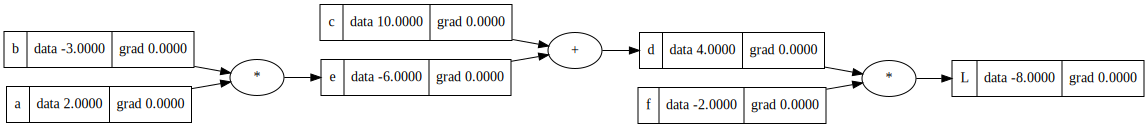

In [10]:
# Let's create some simple Values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Perform a few operations
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

# Check the final Value
L
draw_dot(L)

#Manually Setting Gradients

Before we let our Value class automatically calculate gradients using backpropagation,
let’s first understand what those gradients actually mean and how they’re computed by hand.

We’ll calculate the derivative of the final output L with respect to the input a using the numerical approximation method — by making a tiny change h in a and observing how much L changes.

This helps us verify that our gradient calculations are correct.

In [11]:
def lol():
    h = 0.00001  # a very small step

    # First pass - original value of a
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data  # original output

    # Second pass - slightly change 'a' by h
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data  # new output

    # Numerical derivative (slope)
    print("Approx derivative of L w.r.t a:", (L2 - L1) / h)

# Run the check
lol()


Approx derivative of L w.r.t a: 6.000000000128124


In [12]:
L.grad = 1     # start from output
f.grad = 4     # from d*f → ∂L/∂f = d
d.grad = -2    # ∂L/∂d = f
c.grad = -2    # d = e + c → ∂L/∂c = d.grad * 1 (chain rule)
e.grad = -2    # same as above
b.grad = -6    # e = a*b → ∂L/∂b = a * e.grad
a.grad = -6    # ∂L/∂a = b * e.grad


#Building a Single Neuron


Now that we have our Value class ready, we can simulate a single neuron — the fundamental building block of a neural network.

A neuron takes some inputs, multiplies them by weights, adds a bias, and then applies an activation function (like tanh, ReLU, or sigmoid) to produce an output.

Mathematically:


**n= x1w1 + x2w2 + b**


**o=tanh(n)**

Here:

x1, x2 are the inputs

w1, w2 are the weights

b is the bias

o is the output after applying the activation function

In [14]:
# Inputs to the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights (these are what we’ll eventually “learn”)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias term
b = Value(6.8813735870195432, label='b')

# Linear combination: n = x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Apply tanh activation function
o = n.tanh(); o.label = 'o'

# Display the final output value
o


Value(data=0.7071067811865477, grad=0.0)

In [15]:
# o.grad=1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# w1._backward()
# w2._backward()
# x1._backward()
# x2._backward()

#Backpropagation in Action
Backpropagation automatically computes **gradients** of the output with respect to each input, weight, and bias.
Gradients tell us **how much each parameter contributes to the output**, which is exactly what we use to **update weights during training**.

#What Happens Step by Step:

o.backward() traverses the computation graph from the output back to the inputs.

It computes the derivative of o with respect to each variable:

∂o/∂x1

∂o/∂x2

∂o/∂w1

∂o/∂w2

∂o/∂b

The .grad attribute of each Value object is filled with its corresponding gradient.

draw_dot(o) gives a visual diagram of the computation graph, showing:

Each node’s value (data)

Each node’s gradient (grad)

Operations connecting the nodes

This helps beginners see exactly how values flow forward and gradients flow backward — a very intuitive way to understand neural networks.

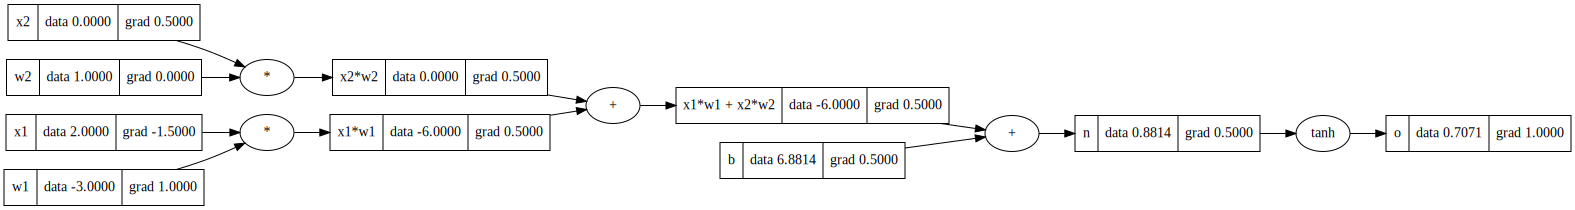

In [15]:
# Perform backpropagation to compute gradients
o.backward()

# Visualize the computation graph with gradients
draw_dot(o)


#Same Computation Using PyTorch
PyTorch makes computing forward and backward passes much simpler because it automatically handles gradients for you.

🔹 **Description**:

We define inputs, weights, and bias as tensors with **requires_grad**=**True**.

Perform the **forward** **pass** with n = x1*w1 + x2*w2 + b and apply tanh activation.

Use **o**.**backward**() to automatically compute gradients for all tensors involved.

.**grad** gives the gradient of the output with respect to each variable.

In [18]:
import torch

# Define inputs
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

# Define weights
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

# Bias
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

# Forward pass
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print("Output:", o.data.item())

# Backward pass
o.backward()

# Gradients
print('---')
print('x1 grad:', x1.grad.item())
print('x2 grad:', x2.grad.item())
print('w1 grad:', w1.grad.item())
print('w2 grad:', w2.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
x1 -1.5000003851533106
w2 0.0
w1 1.0000002567688737


#Building a Deep Neural Network

We are creating a mini neural network framework from scratch.

**Neuron**: represents a single neuron with weights, bias, and optional ReLU activation.

**Layer**: a collection of neurons.

**MLP** (**Multi**-**Layer** **Perceptron**): stacks multiple layers to create a deep network.

This is a manual version similar to PyTorch but teaches the underlying mechanics of forward passes and parameters.


# Simple Explanation :

**Neuron** computes a weighted sum of inputs + bias and applies ReLU if non-linear.

**Layer** is a collection of neurons. Each neuron processes the same input.

**MLP** chains multiple layers together for deep computation.

**parameters**() returns all trainable variables (**weights** and **biases**).

**This framework allows manual forward pass and gradient computation, teaching the mechanics of deep networks before using frameworks like PyTorch**.

In [16]:
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

# Example usage
x = [2.0, 3.0, -1.0]  # input vector
n = MLP(3, [4, 4, 1]) # MLP: 3 inputs, 3 layers (4, 4, 1 neurons)
output = n(x)
print("Network output:", output)


Network output: Value(data=0.0, grad=0.0)


#Testing Neural Network
After building the MLP, we can test it on some sample inputs.

**xs** are the input vectors, **ys** are the expected outputs.

We feed each input to the network and collect predictions

In [17]:
# Sample inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Expected outputs
ys = [1.0, -1.0, -1.0, 1.0]

# Create a new neural network: 3 inputs, 3 layers (4,4,1 neurons)
n = MLP(3, [4, 4, 1])

# Get predictions
ypred = [n(x) for x in xs]
ypred


[Value(data=-0.9007011574787698, grad=0.0),
 Value(data=-0.3077048436001332, grad=0.0),
 Value(data=-0.01629065875677554, grad=0.0),
 Value(data=-0.5181944678243819, grad=0.0)]

#Calculating Loss
Loss tells us how far our neural network’s predictions are from the true values. A simple way to measure this is mean squared error (MSE), which squares the differences between predictions and targets and then averages them.

**This gives a single number representing how well the network is performing. Smaller loss means better predictions**

In [18]:
# predictions from the network
ypred = [n(x) for x in xs]

# calculating mean squared error loss
loss = sum((y_p - y_true)**2 for y_p, y_true in zip(ypred, ys)) / len(ys)
print("Loss:", loss)


Loss: Value(data=1.841133995949397, grad=0.0)


#Backpropagation: Reducing Loss and Increasing Accuracy



In [19]:
# assume we have a simple MLP and computed the loss
loss.backward()  # calculate gradients for all parameters

# learning rate: how big a step we take
lr = 0.01

# update each parameter in the network
for p in n.parameters():
    p.data -= lr * p.grad  # move opposite to the gradient

# reset gradients to zero for the next step
n.zero_grad()


# Training Loop: Improving Accuracy Step by Step

We’ll repeatedly feed our network the inputs, calculate the loss, backpropagate gradients, and update the weights. Over multiple iterations, the network learns and predictions get closer to the true values.

In [20]:
# Sample data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

# Create a small MLP
n = MLP(3, [4, 4, 1])

# Learning rate
lr = 0.01

# Training loop
for epoch in range(50):  # 50 iterations
    ypred = [n(x) for x in xs]  # forward pass
    # Mean Squared Error Loss
    loss = sum((yout - ytrue)**2 for yout, ytrue in zip(ypred, ys)) / len(ys)

    # Reset gradients
    n.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    for p in n.parameters():
        p.data -= lr * p.grad

    if epoch % 10 == 0:  # print every 10 epochs
        print(f"Epoch {epoch}, Loss: {loss.data:.4f}")


Epoch 0, Loss: 1.7849
Epoch 10, Loss: 0.9375
Epoch 20, Loss: 0.7213
Epoch 30, Loss: 0.5456
Epoch 40, Loss: 0.3849
